# Chapter 13: Modeling continuous relationships

In [2]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, ttest_ind
import pingouin as pg
import matplotlib

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
%load_ext rpy2.ipython

# import NHANES package
base = importr('NHANES')
base = importr('fivethirtyeight')

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])
  hate_crimes = ro.conversion.rpy2py(ro.r['hate_crimes'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['Weight']).query('Age > 17 and BPSysAve > 0')

rng = np.random.default_rng(123456)


## Figure 13.1

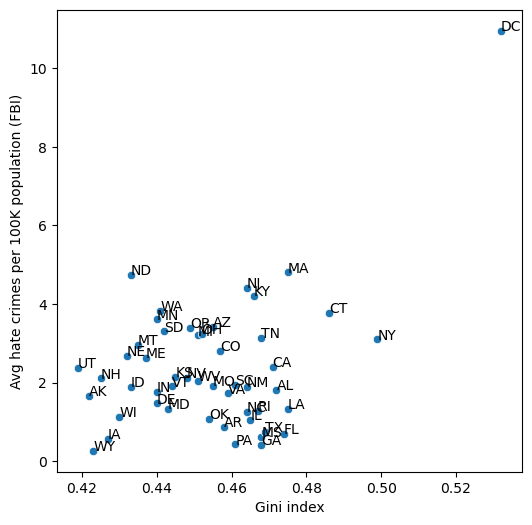

In [2]:
hateCrimes = hate_crimes.dropna(subset=['avg_hatecrimes_per_100k_fbi'])

plt.figure(figsize=(6,6))
sns.scatterplot(data=hateCrimes, x='gini_index', y='avg_hatecrimes_per_100k_fbi')
plt.xlabel('Gini index')
plt.ylabel('Avg hate crimes per 100K population (FBI)')

for i in hateCrimes.index:
    plt.annotate(hateCrimes.loc[i, 'state_abbrev'],
                 xy=[hateCrimes.loc[i, 'gini_index'],
                     hateCrimes.loc[i, 'avg_hatecrimes_per_100k_fbi']])

## Table 13.1

In [5]:
# create data for toy example of covariance
# data vary from book example because they are randomly sampled
covDf = pd.DataFrame({'x': [3, 5, 8, 0, 12]})
covDf['y'] = covDf.x + rng.normal(scale=2, size=5).round()
covDf['y_dev'] = covDf.y - covDf.y.mean()
covDf['x_dev'] = covDf.x - covDf.x.mean()
covDf['crossproduct'] = covDf.y_dev * covDf.x_dev

covDf
      
      

,x,y,y_dev,x_dev,crossproduct
0,3,2.0,-3.4,-2.6,8.84
1,5,4.0,-1.4,-0.6,0.84
2,8,7.0,1.6,2.4,3.84
3,0,1.0,-4.4,-5.6,24.64
4,12,13.0,7.6,6.4,48.64


### Hypothesis testing for correlations

In [4]:
corGiniHC = pg.corr(hateCrimes['gini_index'],
        hateCrimes['avg_hatecrimes_per_100k_fbi'])
corGiniHC

,n,r,CI95%,p-val,BF10,power
pearson,50,0.421272,"[0.16, 0.63]",0.002314,16.02,0.874232


## Figure 13.2

Text(0.5, 0, 'Correlation coeffcients of shuffled variables')

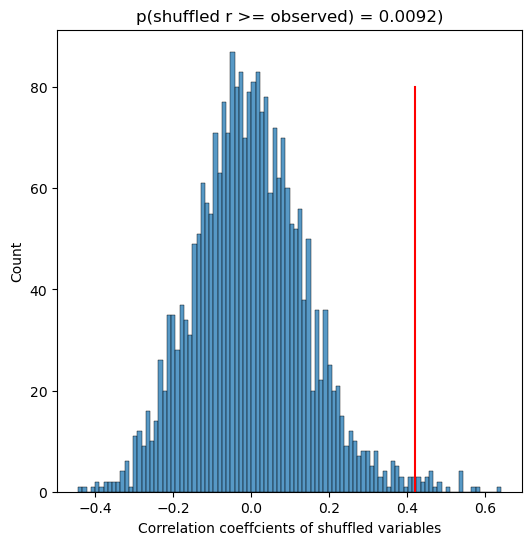

In [5]:
def shuffleCorr(x, y):
    x = x.copy().values
    rng.shuffle(x)
    return(np.corrcoef(x, y.values)[0, 1])

nruns = 2500
shuffleDist = []
for i in range(nruns):
    shuffleDist.append(shuffleCorr(hateCrimes['gini_index'],
            hateCrimes['avg_hatecrimes_per_100k_fbi']))

cc = corGiniHC['r'][0]
plt.figure(figsize=(6,6))
sns.histplot(shuffleDist, bins=100)
plt.title(f'p(shuffled r >= observed) = {np.mean(np.array(shuffleDist) >= cc)})')
plt.plot([cc, cc], [0, 80], color='red')
plt.xlabel("Correlation coeffcients of shuffled variables")

## Figure 13.3

Text(0.5, 1.0, 'r = 0.82 (without outlier: r = -1)')

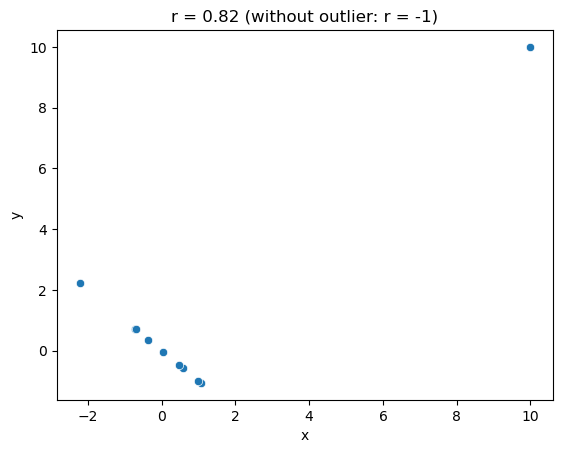

In [6]:
n = 10

dfOutlier = pd.DataFrame({'x': rng.normal(size=n)})
dfOutlier['y'] = dfOutlier.x * -1
dfOutlier.x[0] = 10
dfOutlier.y[0] = 10

cc = dfOutlier.corr().iloc[0, 1]

sns.scatterplot(data=dfOutlier, x='x', y='y')
plt.title(f"r = {cc:.02f} (without outlier: r = -1)")

## Spearman correlation test

In [7]:
corGiniHCSpearman = pg.corr(hateCrimes['gini_index'],
        hateCrimes['avg_hatecrimes_per_100k_fbi'],
        method='spearman')
corGiniHCSpearman

,n,r,CI95%,p-val,power
spearman,50,0.032618,"[-0.25, 0.31]",0.822078,0.055533


## Figure 13.6

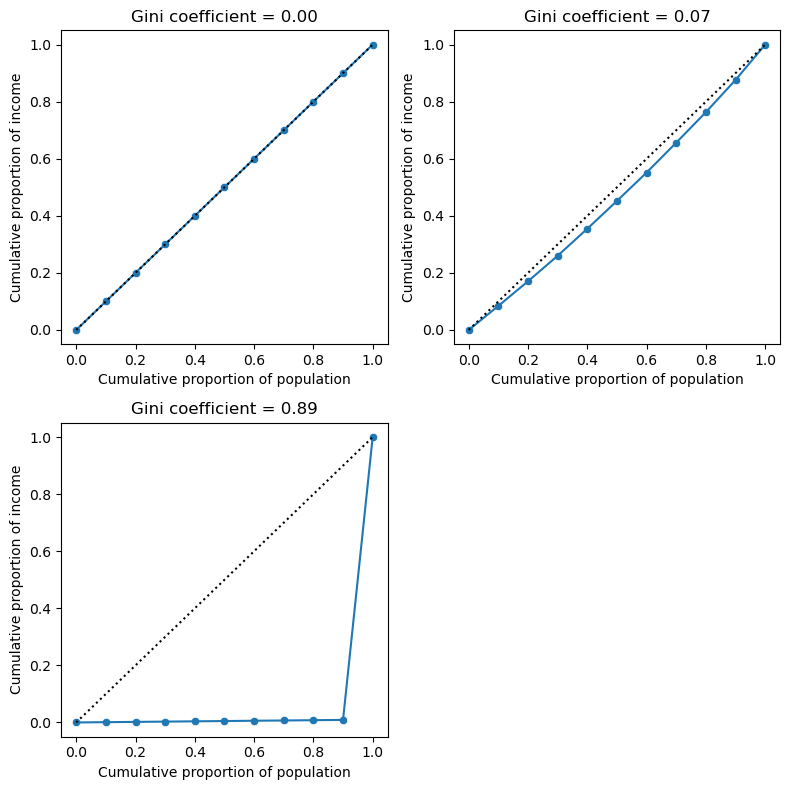

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

def lorenzCurve(values, ax):
    values = values.copy()
    values.sort()
    n = values.shape[0]
    valuesSum = values.sum()
    
    lc = [0]
    p = [0]
    
    for i in range(1, n + 1):
        lc.append(values[:(i)].sum()/valuesSum)
        p.append((i) / n)
    df = pd.DataFrame({'lc': lc, 'p': p})

    S = df.lc.sum()
    giniCoef = 1 + (1 - 2 * S) / n
    sns.lineplot(data=df, x='p', y='lc', ax=ax)
    sns.scatterplot(data=df, x='p', y='lc', ax=ax)
    ax.plot([0, 1], [0, 1], 'k:')
    ax.set_xlabel('Cumulative proportion of population')
    ax.set_ylabel('Cumulative proportion of income')
    ax.set_title(f'Gini coefficient = {giniCoef:.02f}')

    return(df, giniCoef)


income = np.ones(10) * 40000
df, gc = lorenzCurve(income, ax[0][0])

income = rng.normal(loc=40000, scale=5000, size=10)
df, gc = lorenzCurve(income, ax[0][1])

income = np.ones(10) * 40000
income[0] = 40000000
df, gc = lorenzCurve(income, ax[1][0])

ax[1][1].set_visible(False)
plt.tight_layout()

## Bayesian correlation analysis

There is no great equivalent to BayesFactor in Python, so we will use it via the R magic bridge.

In [9]:
%%R -i hateCrimes

library(BayesFactor)
library(bayestestR)

bayesCor <- correlationBF(
  hateCrimes$avg_hatecrimes_per_100k_fbi,
  hateCrimes$gini_index
)
print(bayesCor)
bayesCorPosterior <- describe_posterior(bayesCor)
print(bayesCorPosterior)

R[write to console]: Loading required package: coda

R[write to console]: Loading required package: Matrix

R[write to console]: ************
Welcome to BayesFactor 0.9.12-4.4. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

R[write to console]: Error in library(bayestestR) : there is no package called ‘bayestestR’




Error in library(bayestestR) : there is no package called ‘bayestestR’


RInterpreterError: Failed to parse and evaluate line '\nlibrary(BayesFactor)\nlibrary(bayestestR)\n\nbayesCor <- correlationBF(\n  hateCrimes$avg_hatecrimes_per_100k_fbi,\n  hateCrimes$gini_index\n)\nprint(bayesCor)\nbayesCorPosterior <- describe_posterior(bayesCor)\nprint(bayesCorPosterior)\n'.
R error message: 'Error in library(bayestestR) : there is no package called ‘bayestestR’'